# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [1]:
import os
import sys
from random import randint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load the data table
df = pd.read_csv("../MinION/Taxonomy/Minion_read_based_annotations_genus.normalised.tsv.gz", sep='\t', compression='gzip')
df = df[df['taxonomy'].str.contains('k__Bacteria')]
df = df[~df['taxonomy'].str.endswith('s__')]
df = df[~df['taxonomy'].str.endswith('g__')]
df = df[~df['taxonomy'].str.contains('g__;')]
df = df.set_index('taxonomy')
df.index = df.index.str.split(';').str[-1]

df = df.T

df.head()

taxonomy,g__Candidatus Stahlbacteria,g__Candidatus Chromulinivorax,g__Bradymonas,g__Microvenator,g__Candidatus Acididesulfobacter,g__Candidatus Acidulodesulfobacterium,g__Acanthopleuribacter,g__Candidatus Sulfopaludibacter,g__Edaphobacter,g__Granulicella,...,g__Coraliomargarita,g__Pelagicoccus,g__Puniceicoccus,g__Chthoniobacter,g__Pedosphaera,g__Akkermansia,g__Brevifollis,g__Luteolibacter,g__Verrucomicrobium,g__Candidatus Eremiobacter
825012_20181120_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
698917_20171207_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1586713_20180309_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
748160_20180321_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1593973_20180504_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.775989,0.0


In [3]:
# Load metadata table
# This is generic so we can copy/paste. Yes, it should be a function, but its not.

sequence_type = 'minion_ID'
#sequence_type = 'MGI_ID'

metadata = pd.read_csv("../Metadata/CF_Metadata_Table-JCJ-OD-v-2023-03-23-1352.tsv.gz", encoding='utf-8', sep="\t", compression='gzip', index_col=0)
metadata = metadata[~metadata[sequence_type].isna()]
todrop = []
for s in metadata[sequence_type]:
    if s not in df.index:
        print(f"ERROR: {s} not found in data frame, dropped from metadata", file=sys.stderr)
        todrop.append(s)

metadata.drop(todrop, inplace=True)

todrop = []
for s in df.index:
    if not metadata[sequence_type].str.contains(s).any():
        print(f"ERROR: {s} not found in metadata, dropped from dataframe", file=sys.stderr)
        todrop.append(s)
df.drop(todrop, inplace=True)
        
if metadata.shape[0] != df.shape[0]:
    print(f"ERROR: we have {metadata.shape[0]} rows in metadata and {df.shape[0]} data rows", file=sys.stderr)
metadata.head()

ERROR: 770590_20170925_S not found in data frame, dropped from metadata


,minion_ID,MGI_ID,minion_ID_mismatch_YN,MGI_ID_mismatch_YN,Patient.x,Date.x,IP vs OP,Hospital,Room,Age,...,3 Omalizumab_SC,"3 piperacillin sodium, tazobactam sodium (Tazocin)_IV",2 prednisolone_PO,1 Sulfamethoxazole – trimethoprim (Bactrim)_PO,3 tobramycin_IV,2 tobramycin_INH,Sum of antibiotics,Sum of meds,Sum of antifungals,Sum of steroid + mabs
unique_ID,,,,,,,,,,,,,,,,,,,,,
623361_20180123_S,623361_20180123_S,623361_20180123_S,0,0,623361,2018-01-23T00:00:00Z,OP,RAH,Chest Clinic 9,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639354_20171206_S,639354_20171206_S,639354_20171206_S,0,0,639354,2017-12-06T00:00:00Z,IP,WCH,Adolescent 10,17,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
642660_20180601_S,642660_20180601_S,642660_20180601_S,0,0,642660,2018-06-01T00:00:00Z,IP,WCH,Adol Rm 11,17,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0
650003_20180207_S,650003_20180207_S,650003_20180207_S,0,0,650003,2018-02-07T00:00:00Z,IP,WCH,Adol Room 1,17,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0
658355_20171204_S,658355_20171204_S,658355_20171204_S,0,0,658355,2017-12-04T00:00:00Z,OP,WCH,Gilbert S Meeting,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

<Axes: xlabel='g__Pseudomonas', ylabel='Density'>

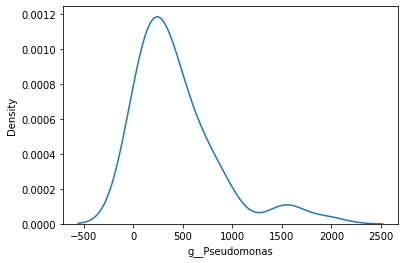

In [5]:
sns.kdeplot(data=df['g__Pseudomonas'])

In [6]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'g__Pseudomonas'
nonzeromean = np.mean(df[df[genus] > 0])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=marker_shapes))

In [7]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

,PC1,PC2
taxonomy,,
g__Streptococcus,-204.491242,7.360812
g__Staphylococcus,90.443682,-10.422926
g__Bacillus,50.601427,29.651822
g__Gemella,-42.725028,-69.333763
g__Prevotella,20.584983,-120.752479


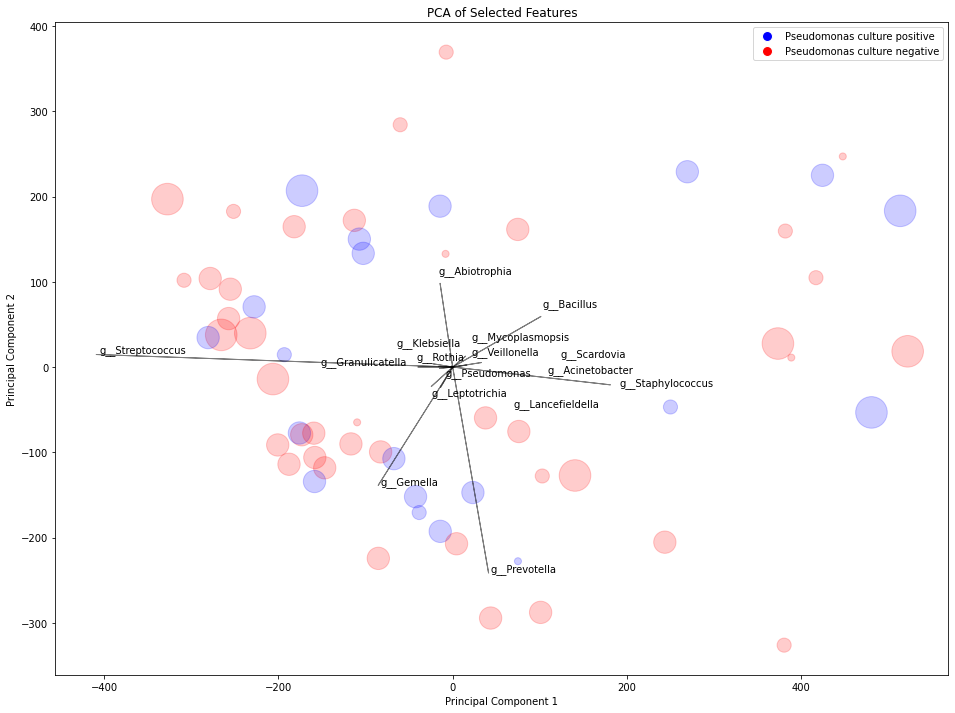

In [23]:
# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('g__Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', markersize=10)
plt.legend(handles=[blue_patch, red_patch])

# Show the plot
plt.show()